#### Import / Global Vars

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from mvo_utils_v2 import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# Global variables
log = True
refresh_pricing = False
universe = 'spy-sectors' # 'spy_sectors OR 'ark_etfs'
active_etf = None # ETF name OR None for broad market
#variables for performance analysis
lb = 60; min_gross=0.5; max_gross=1; min_w=-0.05; max_w=0.05 # default optimization vars
g_samples = 100; gamma_vals = np.logspace(-2, 3, num=g_samples)
min_len = 5; pos_filter = 0.01
rebal_frequency = 'W-WED'

#### Load sector components from hard-drive

In [4]:
# load spy sector components
# would be nice to load a JSON with configuration
ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy-sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark-etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

config = {
    'spy-sectors' : {
        'hold_cols': ['Symbol','Company Name', 'Index Weight'],
        'hold_format': r'holdings-spy-',
        'idx_col': 'Symbol',
        'fname': 'spy-sectors',
        'skiprows': 1
    },
    'ark-etfs' : {
        'hold_cols': ['ticker','company', 'weight(%)'],
        'hold_format': r'holdings-ark-',
        'idx_col': 'ticker',
        'fname': 'ark-etfs',
        'skiprows': 0
    }
}

hold_cols = config[universe]['hold_cols']
hold_format = config[universe]['hold_format']
idx_col = config[universe]['idx_col']
fname = config[universe]['fname']
skiprows = config[universe]['skiprows']

companies = load_components(
    companies, hold_format, hold_cols, 
    idx_col, ticker_map[universe], srows=skiprows)
print("Companies loaded:", companies.shape)
px_etfs = load_pricing(fname + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Companies loaded: (505, 3)
Loaded pricing for spy-sectors.csv, with shape (69, 10)
Loaded pricing for SPY.csv, with shape (69, 1)


#### Get Data from the Server

In [5]:
# Load pricing for components of each sectors
consol_px = clean_nas(load_consol_px(ticker_map, universe))
if(active_etf != None): companies = companies[companies['ETF']==active_etf] # filter by selected ETF
tickers = companies.index.tolist()
tickers=[i for i in tickers if i not in ['BF.b','BRK.b']] ## esta es una correcion extra para no incluir 'BF.b','BRK.b'
consol_px = consol_px[list(set(tickers))]

Loaded pricing for XLE-hold-pricing.csv, with shape (69, 32)
Loaded pricing for XLU-hold-pricing.csv, with shape (69, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (69, 71)
Loaded pricing for XLB-hold-pricing.csv, with shape (69, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (69, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (69, 84)
Loaded pricing for XLI-hold-pricing.csv, with shape (69, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (69, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (69, 67)
Loaded pricing for XLRE-hold-pricing.csv, with shape (69, 33)


#### Generate Trading Recomendations

In [6]:
# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN']
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0:
    consol_px.drop(remove, axis=1, inplace=True)
consol_px.shape
consol_px = consol_px[sorted(consol_px.columns.tolist())]
consol_px.to_csv("consol_algo.csv")
consol_px[consol_px.columns[:10]].tail(3)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI
Date,,,,,,,,,,
2018-03-13,70.680000,56.230000,119.000000,179.970001,119.750000,100.599998,63.200001,162.490005,219.759995,94.660004
2018-03-14,69.919998,55.279999,117.059998,178.440002,118.940002,98.580002,62.860001,161.000000,218.440002,94.089996
2018-03-15,70.230003,55.000000,117.050003,179.330002,116.221001,97.557503,62.785000,161.990005,219.210007,93.820000


In [7]:
# LONG-SHORT # portfolio optimization
# long-short version of recommend allocations
def ls_recommend_allocs(px, lb, min_sum, max_sum, min_w, max_w, gamma_val):
    px = clean_nas(px) # clean dataframe
    px_portion = px[-lb:].copy() # subselect the period to optimize; frame and lb were duplicatives
    returns, alloc = ls_get_weights(
        px_portion, lb, min_sum, max_sum, min_w, max_w, gamma_val) # subselect the period to optimize
    port_perf = calc_port_performance(returns.values, alloc.values)
    pdf = pd.DataFrame(port_perf, index=returns.index, columns=["Quantum"])
    return px_portion, returns, alloc, pdf
# long-short version of optimization, position weights
def ls_get_weights(px, lb, min_sum, max_sum, min_w, max_w, gamma_val):
    lb_rets = px.sort_index().pct_change().dropna() # capture the last lb days going back
    n = lb_rets.shape[1]; mu = lb_rets.mean().values.T; Sigma = lb_rets.cov().values
    w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    Lmax = cvx.Parameter()
    ret = mu.T * w; risk = cvx.quad_form(w, Sigma)
    lo_obj = cvx.Maximize(ret - gamma*risk)
    #lo_const = [cvx.sum_entries(w) >= min_sum, cvx.sum_entries(w) <= max_sum, w > min_w, w < max_w]
    ls_const = [cvx.sum_entries(w) >= min_sum, cvx.norm(w, 1) < Lmax, w <= max_w, w >= min_w]
    prob = cvx.Problem(lo_obj, ls_const)
    gamma.value = gamma_val; Lmax.value = max_sum
    prob.solve()
    if prob.status == 'optimal': weights = w.value
    else: weights = np.zeros((n, 1))
    np_weights = np.array(weights)
    lb_weights = pd.DataFrame(np_weights.T, index=[lb_rets.index[-1]], columns=lb_rets.columns)
    return lb_rets, lb_weights
# pending implementation using partials
def quick_gamma(glist, c_px, t_w, lb, mi_g, ma_g, mi_w, ma_w):
    if len(glist) <= 1: 
        mid_g = glist[0]
        mid_sr = get_sr_for_opt(c_px, t_w, lb, mi_g, ma_g, mi_w, ma_w, mid_g)
        return mid_g, mid_sr
    else:
        mid = len(glist)//2; left = glist[:mid]; right = glist[mid:]
        mid_l = left[len(left)//2]; mid_r = right[len(right)//2]
        left_sr = get_sr_for_opt(c_px, t_w, lb, mi_g, ma_g, mi_w, ma_w, mid_l)
        right_sr = get_sr_for_opt(c_px, t_w, lb, mi_g, ma_g, mi_w, ma_w, mid_r)
        if left_sr > right_sr: sublist = left
        else: sublist = right
        return quick_gamma(sublist, c_px, t_w, lb, mi_g, ma_g, mi_w, ma_w)
# return portfolio sharpe for a given optimization
def get_sr_for_opt(c_px, t_w, lb, mi_g, ma_g, mi_w, ma_w, gamma):
    px_p, _, alloc, pdf = ls_recommend_allocs(c_px, lb, mi_g, ma_g, mi_w, ma_w, gamma)
    rec = last_allocation(alloc, 0.01)
    ret, risk = port_metrics(px_p, rec)
    return ret / risk

In [8]:
# cleans small positions in long-short portfolios based on minimum weight criteria
def filter_ls(rec, pos_filter):
    long = rec[(rec > pos_filter).values]; short = rec[(rec < -pos_filter).values]
    return long.append(short)
#calculates the historical allocations based on a date frequency
def get_hist_allocs(rebal_freq, px, g_samples, min_len, pos_filter):
    as_of_idx = px.index.to_period(freq=rebal_freq).drop_duplicates().to_timestamp().to_native_types()
    hist_allocs = pd.DataFrame([], index=as_of_idx)
    if log: print(len(as_of_idx), "rebalances"); print(as_of_idx)
    for d in as_of_idx: 
        subset = consol_px.loc[:d]; days = len(subset)
        if days < min_len: continue
        gamma_val, gamma_sr = quick_gamma(
            gamma_vals, subset, hist_window, lb, min_gross, max_gross, min_w, max_w)
        if log: print("rebalancing: {0:s}, {1:.2f}, {2:.2f}".format(d, gamma_val, gamma_sr))
        px_portion, returns, alloc, pdf = ls_recommend_allocs(
            subset, lb, min_gross, max_gross, min_w, max_w, gamma_val)
        rec = last_allocation(alloc, min_w)
        l_s = filter_ls(rec, pos_filter)
        hist_allocs = hist_allocs.combine_first(alloc[l_s.index])
    return hist_allocs
# alings allocations with trading days
def align_ret_allocs(allocs, px):
    returns = px.pct_change().fillna(0)[allocs.columns]
    upsample_alloc = allocs.resample('D').pad()
    upsample_alloc = upsample_alloc.loc[returns.index]
    return returns, upsample_alloc

In [9]:
# calculates gamma for a single date
d = '2018-01-11'
#subset = consol_px.loc[:d]
subset = consol_px
gamma_val, gamma_sr = quick_gamma(gamma_vals, subset, hist_window, lb, min_gross, max_gross, min_w, max_w)

In [11]:
# sensitividad clave: cual es net exposure optimo que maximiza retorno y minimizar el riesgo
# pendiente correr con pesos limitantes mas grandes
# pendiente implementar calculo de drawndown para un time series (dentro portfolio metrics)
# pendiente hacer los mismo para bechmark y ensenar differencias

log = False
net_exposures = np.arange(0.0, 1.01, 0.1)
cols = ['Return', 'Risk', 'Sharpe', 'Return Spread', 'Max Drawdown']
perf_metrics = pd.DataFrame([], index=net_exposures, columns=cols)
perf_metrics.index.name = 'Net Exposure'
for ne in net_exposures:
    min_gross = ne
    hist_allocs = get_hist_allocs(rebal_frequency, consol_px, g_samples, min_len, pos_filter)
    returns, allocs = align_ret_allocs(hist_allocs, consol_px)
    indexed_time_series = calc_port_performance(returns, allocs).to_frame()
    indexed_time_series.columns = ['Quantum']
    ret, risk, sr = portfolio_metrics('L/S', indexed_time_series)
    perf_metrics.loc[ne] = [ret, risk, sr, ret - risk, -1]
perf_metrics = perf_metrics.sort_values(by='Return Spread', ascending=False)
perf_metrics

/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


L/S Return: 0.12, StdDev: 0.05, Sharpe: 2.30
L/S Return: 0.13, StdDev: 0.05, Sharpe: 2.58
L/S Return: 0.12, StdDev: 0.05, Sharpe: 2.30
L/S Return: 0.12, StdDev: 0.05, Sharpe: 2.51
L/S Return: 0.14, StdDev: 0.05, Sharpe: 2.81
L/S Return: 0.13, StdDev: 0.05, Sharpe: 2.51
L/S Return: 0.11, StdDev: 0.05, Sharpe: 2.08
L/S Return: 0.13, StdDev: 0.05, Sharpe: 2.38
L/S Return: 0.10, StdDev: 0.06, Sharpe: 1.66
L/S Return: 0.13, StdDev: 0.07, Sharpe: 1.94
L/S Return: 0.13, StdDev: 0.07, Sharpe: 1.72


,Return,Risk,Sharpe,Return Spread,Max Drawdown
Net Exposure,,,,,
0.4,0.144203,0.0513153,2.81014,0.0928879,-1
0.1,0.13011,0.0504117,2.58095,0.0796982,-1
0.5,0.127874,0.0509855,2.50806,0.076889,-1
0.7,0.130892,0.0549498,2.38202,0.075942,-1
0.3,0.118029,0.0470671,2.50767,0.0709617,-1
0.2,0.11792,0.0511858,2.30377,0.0667347,-1
0.0,0.118128,0.051443,2.29629,0.0666849,-1
0.9,0.131271,0.0675697,1.94274,0.0637009,-1
0.6,0.114231,0.0549898,2.07731,0.0592411,-1


In [14]:
# run portfolio with best net exposure
min_gross = perf_metrics.index[0] # updates with best net exposure
px_portion, returns, alloc, pdf = ls_recommend_allocs(
        consol_px, lb, min_gross, max_gross, min_w, max_w, gamma_val)
rec = last_allocation(alloc, min_w)
recommend = filter_ls(rec, pos_filter)
tickers = recommend.index.tolist()

In [15]:
cos_no_dup = companies.drop_duplicates(subset='Company')
recommend['Sector'] = cos_no_dup.loc[tickers]['ETF']
recommend['Company'] = cos_no_dup.loc[tickers][['Company']]
recommend = recommend.astype({"Allocation": np.float})
recommend[['Company', 'Sector', 'Allocation']]
# esto debe estar dentro de portfolio metrics
print("{} Positions, {} Long, {} Short, Long Exposure: {}, Short Exposure {}".format(
    len(recommend.index), 
    len(recommend[recommend['Allocation'] > 0]), 
    len(recommend[recommend['Allocation'] < 0 ]),
    recommend[recommend['Allocation'] > 0]['Allocation'].sum(),
    recommend[recommend['Allocation'] < 0]['Allocation'].sum())
     )
recommend

30 Positions, 20 Long, 10 Short, Long Exposure: 0.6946126152669861, Short Exposure -0.29416273773014384


,Allocation,Sector,Company
AMZN,0.050000,XLY,Amazon.com Inc
APC,0.050000,XLE,Anadarko Petroleum Corp
CAH,0.018439,XLV,Cardinal Health Inc
EA,0.040452,XLK,Electronic Arts
EL,0.031307,XLP,Estee Lauder Cos. A
EVHC,0.050000,XLV,Envision Healthcare Corp
EW,0.041483,XLV,Edwards Lifesciences Corp
FISV,0.024341,XLK,Fiserv Inc
GWW,0.021090,XLI,Grainger W.W. Inc
HUM,0.018064,XLV,Humana Inc


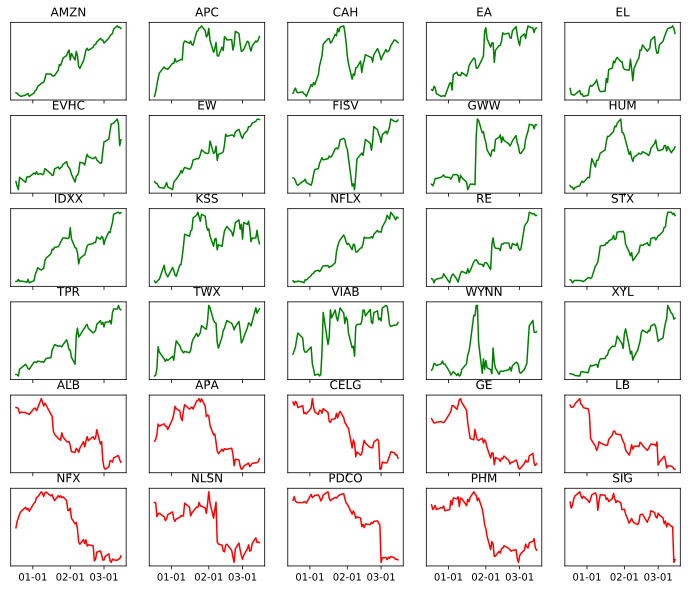

In [16]:
# plots all tickers to verify if there are any M&A targets
nbr_charts = len(sorted(tickers)); cols = 5
fig, ax = plt.subplots(nbr_charts // cols, cols, figsize=(12,10), sharex=True)
for i, axi in enumerate(ax.flat):
    co = tickers[i]; df_range = consol_px[co][-lb:]
    weight = recommend.loc[co]['Allocation']
    color = '-g' 
    if weight < 0: color = '-r'
    axi.plot(df_range.index.to_datetime().tolist(), df_range.values, color)
    axi.set(title=co)
    axi.yaxis.set_major_locator(plt.NullLocator())
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

In [17]:
sect_group_stats(recommend, 'Sector').sort_values(by='Sector Weight', ascending=False)

Total % Allocation 40.04


,Sector Weight,Avg Position
XLV,0.119886,0.017127
XLK,0.114792,0.038264
XLY,0.079799,0.007980
XLF,0.050000,0.050000
XLP,0.031307,0.031307
XLI,0.023340,0.005835
XLE,0.002865,0.000955
XLB,-0.021539,-0.021539


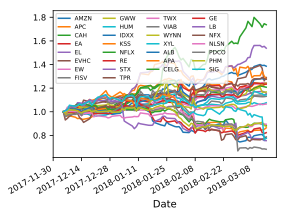

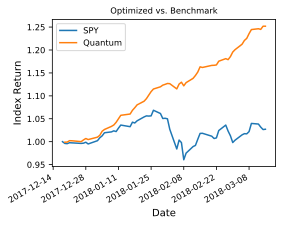

In [18]:
ax = compound(consol_px[recommend.index][-hist_window:]).plot(fontsize='small', figsize=(4,3))
ax.legend(fontsize='xx-small', ncol=4)
idx = px_spy.iloc[-(len(pdf.index)+1):].index
idx_px_spy = compound(px_spy.loc[idx])
plot_two_series(idx_px_spy, pdf, 'SPY', 'Quantum', 'Date', 'Index Return', 'Optimized vs. Benchmark')
# need to add 1 at the begining of pdf

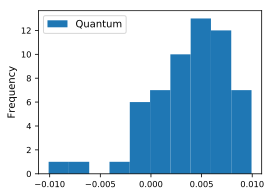

In [19]:
pdf.pct_change().plot(kind='hist', figsize=(4,3), fontsize='small')

In [20]:
# Outputs for trade execution
px = consol_px[tickers][-lb:]
date = px[-1:].index.to_datetime().strftime(date_fmt)[0]
ret, risk = port_metrics(px_portion, rec)

trading_cols = ['Company', 'Price', 'Allocation', 'Dollar Value', 'Shares']
trading_df = pd.DataFrame([], index=recommend.index, columns=trading_cols)

round_shares = lambda x: round(x, 0)
port_bal = 231000; alloc = recommend['Allocation']
pvalue = (port_bal * alloc)
shares = (port_bal * alloc) / px[-1:]
shares.apply(round_shares).T.sort_index()

trading_df['Company'] = recommend['Company']
trading_df['Price'] = px[-1:].T
trading_df['Allocation'] = recommend['Allocation']
trading_df['Dollar Value'] = trading_df['Allocation'] * port_bal
trading_df['Shares'] = trading_df['Dollar Value'] / trading_df['Price']

print("Time Window: {}, Lookback: {}, MinGross: {}, MaxGross: {}, MinWeight: {}, MaxWeight: {}".format(hist_window, lb, min_gross, max_gross, min_w, max_w))
print("Ann. Ret: {0:.2f}, Risk: {1:.2f} Sharpe: {2:.2f}".format(ret, risk, ret / risk))
print("Date: {0}, Total Invested: {1:.2f}, Total Allocation: {2:.2f}%".format(date, trading_df['Dollar Value'].sum(), trading_df['Allocation'].sum() * 100))
trading_df.head()
trading_df = trading_df.astype({'Dollar Value':np.int, 'Shares':np.int})
trading_df.sort_index()

Time Window: 100, Lookback: 60, MinGross: 0.4, MaxGross: 1, MinWeight: -0.05, MaxWeight: 0.05
Ann. Ret: 0.23, Risk: 0.03 Sharpe: 7.33
Date: 2018-03-15, Total Invested: 92503.92, Total Allocation: 40.04%


,Company,Price,Allocation,Dollar Value,Shares
ALB,Albemarle Corp,98.849998,-0.021539,-4975,-50
AMZN,Amazon.com Inc,1581.880005,0.050000,11549,7
APA,Apache Corp,36.229900,-0.019032,-4396,-121
APC,Anadarko Petroleum Corp,59.590000,0.050000,11549,193
CAH,Cardinal Health Inc,71.800003,0.018439,4259,59
CELG,Celgene Corp,90.519997,-0.029002,-6699,-74
EA,Electronic Arts,128.130005,0.040452,9344,72
EL,Estee Lauder Cos. A,143.710007,0.031307,7231,50
EVHC,Envision Healthcare Corp,40.299999,0.050000,11549,286
EW,Edwards Lifesciences Corp,140.759995,0.041483,9582,68


#### Ejemplos

L/S Return: 0.26, StdDev: 0.10, Sharpe: 2.71
(0.2523105485338122, 0.09636079585660047)


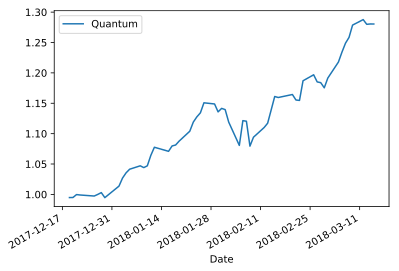

In [246]:
# show the performance using the LAST allocation, not realistic
px_portion, returns, alloc, pdf = ls_recommend_allocs(consol_px, lb, min_gross, max_gross, min_w, max_w, gamma_val)
rec = last_allocation(alloc, min_w)
l_s = filter_ls(rec, pos_filter)
portfolio_metrics('L/S', pdf)
print(port_metrics(px_portion, l_s))
pdf.plot()

In [172]:
# ejemplo: calcula la matris de pesos historicos rebalanceando semanalmente
hist_allocs = get_hist_allocs(rebal_frequency, consol_px, g_samples, min_len, pos_filter)
# nota que hay una semana sin pesos

rebalancing: 2017-12-14, 1000.00, 8.87
rebalancing: 2017-12-21, 705.48, 8.96
rebalancing: 2017-12-28, 312.57, 8.93
rebalancing: 2018-01-04, 278.26, 7.40
rebalancing: 2018-01-11, 196.30, 7.77
rebalancing: 2018-01-18, 559.08, 6.26
rebalancing: 2018-01-25, 86.97, 7.38
rebalancing: 2018-02-01, 443.06, 6.05
rebalancing: 2018-02-08, 27.19, 2.45


/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars


rebalancing: 2018-02-15, 312.57, nan
rebalancing: 2018-02-22, 43.29, 3.02
rebalancing: 2018-03-01, 48.63, 2.93
rebalancing: 2018-03-08, 54.62, 3.33
rebalancing: 2018-03-15, 54.62, 3.05


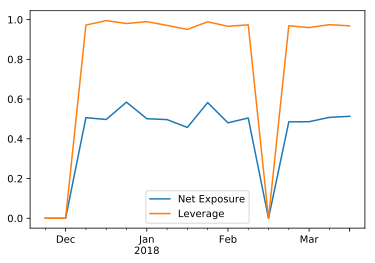

In [185]:
# ejemplo: ensena net exposure y leverage, consistent con limitantes
cols = ['Net Exposure','Leverage']
df = pd.DataFrame([], index=hist_allocs.index, columns=cols)
df[cols[0]] = hist_allocs.sum(axis=1)
df[cols[1]] = hist_allocs.abs().sum(axis=1)
df.plot()

L/S Return: 0.13, StdDev: 0.05, Sharpe: 2.51


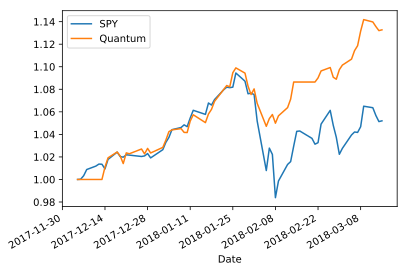

In [225]:
# ejemplo: calcula retorno acumulado tomando en cuenta los rebalanceos semanales
returns, allocs = align_ret_allocs(hist_allocs, consol_px)
indexed_time_series = calc_port_performance(returns, allocs).to_frame()
indexed_time_series.columns = ['Quantum']
portfolio_metrics('L/S', indexed_time_series)

idx = px_spy.iloc[-(len(indexed_time_series.index)+1):].index
idx_px_spy = compound(px_spy.loc[idx])
ax = idx_px_spy.plot()
indexed_time_series.plot(ax=ax)
# retorno es menor porque el rebalanceado se hace con informacion disponible a cada semana

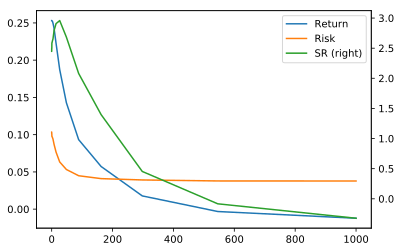

In [269]:
# Calculates the portofolio 
as_of = consol_px.index.to_datetime()[-1:] # date as of when we want the weights vector
SAMPLES = 20; gamma_vals = np.logspace(-2, 3, num=SAMPLES)
metrics = np.zeros((SAMPLES, 3))
for i, g in enumerate(gamma_vals):
    px_portion, returns, alloc, pdf = ls_recommend_allocs(
        consol_px, lb, min_gross, max_gross, min_w, max_w, g)
    rec = last_allocation(alloc, min_w)
    l_s = filter_ls(rec, pos_filter)
    ret, risk = port_metrics(px_portion, l_s)
    metrics[i] = [ret, risk, ret / risk]
metrics_df = pd.DataFrame(metrics, index=gamma_vals, columns=['Return', 'Risk', 'SR'])
metrics_df.plot(secondary_y=['SR'])

In [28]:
# range of potential gammas using logspace
as_of = consol_px.index.to_datetime()[-1:] # date as of when we want the weights vector
SAMPLES = 1000; gamma_vals = np.logspace(-2, 3, num=SAMPLES)
%time gamma_val, gamma_sr = quick_gamma(gamma_vals, consol_px, hist_window, lb, as_of, min_gross, max_gross, min_w, max_w)
print("Gamma: {0:.2f}, SR Ratio {1:.2f}, Lookback: {2}, Max Weight: {3}".format(gamma_val, gamma_sr, lb, max_w))

CPU times: user 6.95 s, sys: 453 ms, total: 7.4 s
Wall time: 4.45 s
Gamma: 86.88, SR Ratio 0.31, Lookback: 60, Max Weight: 0.05


#### Utility Cells

In [248]:
weights = np.zeros((len(consol_px.columns), 1))
np_weights = np.array(weights)
lb_rets = consol_px.sort_index().pct_change().dropna()
lb_weights = pd.DataFrame(np_weights.T, index=[lb_rets.index[-1]], columns=lb_rets.columns)

In [188]:
# illustration of how two allocation frames can be combined
df1 = pd.DataFrame(np.arange(0,6,1).reshape(2,3), index=[1,2], columns=list('abc'))
df2 = pd.DataFrame(np.arange(6,12,1).reshape(2,3), index=[1,2], columns=list('cde'))
df1.combine_first(df2)

,a,b,c,d,e
1,0,1,2,7.0,8.0
2,3,4,5,10.0,11.0


In [189]:
# illustration of how two allocation frames can be combined
df1 = pd.DataFrame(np.arange(0,6,1).reshape(2,3), index=[1,2], columns=list('abc'))
df2 = pd.DataFrame(np.arange(6,12,1).reshape(2,3), index=[3,4], columns=list('cde'))
df1.combine_first(df2)

,a,b,c,d,e
1,0.0,1.0,2.0,NaN,NaN
2,3.0,4.0,5.0,NaN,NaN
3,NaN,NaN,6.0,7.0,8.0
4,NaN,NaN,9.0,10.0,11.0
